# Twitter Data Processing & Sentiment Analysis

Parts of the code in this notebook may be taken from:
- Kirrane, S., "Data Processing II" Course Materials
- Datacamp, "Introduction to PySpark" Course Materials


## Setting up the Spark Session & Installing Packages

In [1]:
# Import the os module 
import os

# Set the PYSPARK_SUBMIT_ARGS to the appropriate spark-sql-kafka package
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.1 pyspark-shell'

In [2]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install findspark

# Import the findspark module 
import findspark

# Initialize via the full spark path
findspark.init("/usr/local/spark/")

In [3]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pyspark

# Import the SparkSession and SQLContext modules
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Build the SparkSession
spark = SparkSession.builder \
   .master("local") \
   .appName("Processing Accounts") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()
   
# Main entry point for Spark functionality. A SparkContext represents the
# connection to a Spark cluster, and can be used to create :class:`RDD` and
# broadcast variables on that cluster.      
sc = spark.sparkContext

In [4]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install nltk

# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install langid

# Download averaged_perceptron_tagger from the nltk
import nltk
nltk.download('averaged_perceptron_tagger')

# Download stopwords from the nltk
import nltk
nltk.download('stopwords')

# Download wordnet from the nltk
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Register all the functions in Preproc with Spark Context

In [5]:
# Import the udf, StringType, and pp modules
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import preproc as pp


# Creates a user defined function (UDF).
# Stop words usually refer to the most common words in a language, there is no single universal list of stop words used
# by all natural language processing tools.
# Reduces Dimensionality
# removes stop words of a single Tweets (cleaned_str/row/document)
remove_stops_udf = udf(pp.remove_stops, StringType())

# Creates a user defined function (UDF).
# catch-all to remove other 'words' that I felt didn't add a lot of value
# Reduces Dimensionality, gets rid of a lot of unique urls
remove_features_udf = udf(pp.remove_features, StringType())

# Creates a user defined function (UDF).
# Process of classifying words into their parts of speech and labeling them accordingly is known as part-of-speech
# tagging, POS-tagging, or simply tagging. Parts of speech are also known as word classes or lexical categories. The
# collection of tags used for a particular task is known as a tagset. Our emphasis in this chapter is on exploiting
# tags, and tagging text automatically.
# http://www.nltk.org/book/ch05.html
tag_and_remove_udf = udf(pp.tag_and_remove, StringType())

# Creates a user defined function (UDF).
# Tweets are going to use different forms of a word, such as organize, organizes, and
# organizing. Additionally, there are families of derivationally related words with similar meanings, such as democracy,
# democratic, and democratization. In many situations, it seems as if it would be useful for a search for one of these
# words to return documents that contain another word in the set.
# Reduces Dimensionality and boosts numerical measures like TFIDF
# http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html
# lemmatization of a single Tweets (cleaned_str/row/document)
lemmatize_udf = udf(pp.lemmatize, StringType())

# Creates a user defined function (UDF).
# check to see if a row only contains whitespace
check_blanks_udf = udf(pp.check_blanks, StringType())


## Pre-Processing

#### Additional sources:
- Migration Guide: SQL, Datasets and DataFrame—Spark 3.0.1 Documentation. (n.d.). Retrieved 8 February 2021, from https://spark.apache.org/docs/latest/sql-migration-guide.html#query-engine


In [7]:
try:
    # loading the all of the streamed tweets to the app
    df = spark \
      .read \
      .format("kafka") \
      .option("kafka.bootstrap.servers", "localhost:9092") \
      .option("subscribe", "Stream_accounts") \
      .load()
    df = df.selectExpr("CAST(value AS STRING)")

    # extracting the json data into a dataframe
    text_tweets = df.select(df.value, json_tuple(df.value, 'created_at','text').alias('created_at', 'text'))

    # selecting the relevant columns for our further analysis
    data_df = text_tweets.select('created_at', 'text')
    
except:
    # Print the error
    print("Unexpected error:", sys.exc_info()[0])     

In [8]:
try:
    # Returns a new :class:`DataFrame` by adding a column or replacing the
    # existing column that has the same name.
    # Use 'remove_stops_udf' remove stop words to reduce dimensionality
    #rm_stops_df = en_df.withColumn("stop_text", remove_stops_udf(en_df["text"]))
    data_df = data_df.withColumn("text", remove_stops_udf(data_df["text"]))

    # Returns a new :class:`DataFrame` by adding a column or replacing the
    # existing column that has the same name.
    # Use 'remove_features_udf' to remove other non essential words, think of it as my personal stop word list
    #rm_features_df = rm_stops_df.withColumn("feat_text", remove_features_udf(rm_stops_df["stop_text"]))
    data_df = data_df.withColumn("text", remove_features_udf(data_df["text"]))

    # Returns a new :class:`DataFrame` by adding a column or replacing the
    # existing column that has the same name.
    # Use 'tag_and_remove_udf' to tag the words remaining and keep only Nouns, Verbs and Adjectives
    #rm_features_df = rm_stops_df.withColumn("feat_text", remove_features_udf(rm_stops_df["stop_text"]))
    data_df = data_df.withColumn("text", tag_and_remove_udf(data_df["text"]))

    # Returns a new :class:`DataFrame` by adding a column or replacing the
    # existing column that has the same name.
    # Use lemmatize_udf' to lemmatize the remaining words in order to reduce dimensionality & boost measures
    #lemm_df = tagged_df.withColumn("lemm_text", lemmatize_udf(tagged_df["tagged_text"]))
    data_df = data_df.withColumn("text", lemmatize_udf(data_df["text"]))

    # Returns a new :class:`DataFrame` by adding a column or replacing the
    # existing column that has the same name.
    # Use 'check_blanks_udf' to remove all rows containing only blank spaces
    #check_blanks_df = lemm_df.withColumn("is_blank", check_blanks_udf(lemm_df["lemm_text"]))
    #no_blanks_df = check_blanks_df.filter(check_blanks_df["is_blank"] == "False")
    data_df = data_df.withColumn("is_blank", check_blanks_udf(data_df["text"]))
    data_df = data_df.filter(data_df["is_blank"] == "False")

    # Return a new :class:`DataFrame` with duplicate rows removed,
    # optionally only considering certain columns.
    data_df = data_df.dropDuplicates(['text'])

    data_df.show()
    
except:
    # Print the error
    print("Unexpected error:", sys.exc_info()[0])  

+--------------------+--------------------+--------+
|          created_at|                text|is_blank|
+--------------------+--------------------+--------+
|Wed Feb 03 08:27:...|dear elon release...|   False|
|Wed Feb 03 08:25:...|haha guess bitcoi...|   False|
|Tue Feb 02 19:12:...|honesty matter fa...|   False|
|Tue Feb 02 19:11:...|carry world versa...|   False|
|Tue Feb 02 17:58:...|               lmfao|   False|
|Tue Feb 02 17:56:...|bitcoin eth amp u...|   False|
|Tue Feb 02 19:12:...|    meme time please|   False|
|Tue Feb 02 17:59:...|         stay please|   False|
|Wed Feb 03 08:24:...|thanks friend sha...|   False|
|Wed Feb 03 08:27:...|thanks tesla team...|   False|
|Tue Feb 02 19:14:...|possible xrp mark...|   False|
|Tue Feb 02 17:54:...|   supporter bitcoin|   False|
|Tue Feb 02 19:14:...|gamestop put bitc...|   False|
|Tue Feb 02 19:13:...|miss know digital...|   False|
|Tue Feb 02 17:57:...|stay busy big daw...|   False|
|Tue Feb 02 17:55:...|seem realize late...|   

In [ ]:
# converting created_at column values to timestamp
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import col

try:
    spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

    data_df = data_df.withColumn("created_at",to_timestamp(col("created_at"),"EEE MMM dd HH:mm:ss Z yyyy"))
    
except:
    # Print the error
    print("Unexpected error:", sys.exc_info()[0])  

In [ ]:
try:
    #filtering by currency and saving in different dataframes
    tweets_btc = (data_df.filter((data_df.text.contains('bitcoin') | data_df.text.contains('btc')))).select('text', 'created_at')
    tweets_eth = (data_df.filter((data_df.text.contains('etherum') | data_df.text.contains('eth')))).select('text', 'created_at')
    tweets_link = (data_df.filter((data_df.text.contains('chainlink') | data_df.text.contains('link')))).select('text', 'created_at')
    tweets_doge = (data_df.filter((data_df.text.contains('dogecoin') | data_df.text.contains('doge')))).select('text', 'created_at')
    tweets_ltc = (data_df.filter((data_df.text.contains('litecoin') | data_df.text.contains('ltc')))).select('text', 'created_at')
    
except:
    # Print the error
    print("Unexpected error:", sys.exc_info()[0])  

In [ ]:
# commented: showing the preprocessed dataframes

# tweets_btc.show()
# tweets_eth.show()
# tweets_link.show()
# tweets_doge.show()
# tweets_ltc.show()

## VADER Sentiment Analysis

#### License, copyright and requested citation:
- [The MIT License (MIT)](https://github.com/cjhutto/vaderSentiment/blob/master/LICENSE.txt)
- Copyright (c) 2016 C.J. Hutto
- Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

#### Additional Sources:
- Panchal, S. (2020, June 19). Sentiment Analysis with VADER- Label the Unlabeled Data. Medium. https://medium.com/analytics-vidhya/sentiment-analysis-with-vader-label-the-unlabeled-data-8dd785225166


In [ ]:
# Download VADER sentiment from the nltk
import nltk
nltk.download('vader_lexicon')

# Importing the function 
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Creating an instance
vd = SentimentIntensityAnalyzer()

In [ ]:
from pyspark.sql.functions import udf

# creating a custom function: applying the sentiment analysis, retrieving the weighted score
#  after that rewriting the score to 1 (positive), -1 (negative) or 0 (neutral) to simplify & amplify results
def sentiment_score(text):
    score = vd.polarity_scores(text).get('compound')
    if score < -0.01:
        score = -1
    if score > 0.01:
        score = 1
    else:
        score = 0
    return score

# creating a user defined function (UDF), from the custom function
sentiment_score_udf = udf(sentiment_score, IntegerType())

In [ ]:
try:
    # applying the custom sentiment function to all dataframes, saving results in a new column
    tweets_btc = tweets_btc.withColumn("sentiment", sentiment_score_udf(tweets_btc["text"]))
    tweets_eth = tweets_eth.withColumn("sentiment", sentiment_score_udf(tweets_eth["text"]))
    tweets_link = tweets_link.withColumn("sentiment", sentiment_score_udf(tweets_link["text"]))
    tweets_doge = tweets_doge.withColumn("sentiment", sentiment_score_udf(tweets_doge["text"]))
    tweets_ltc = tweets_ltc.withColumn("sentiment", sentiment_score_udf(tweets_ltc["text"]))
    
except:
    # Print the error
    print("Unexpected error:", sys.exc_info()[0])  

In [14]:
try:
    # grouping the created dataframes by timestamp (each minute) with the average sentiment score and sorting by timestamp
    tweets_btc_grouped = tweets_btc.groupBy(window("created_at", "1 minutes")).avg("sentiment").sort('window')
    tweets_eth_grouped = tweets_eth.groupBy(window("created_at", "1 minutes")).avg("sentiment").sort('window')
    tweets_link_grouped = tweets_link.groupBy(window("created_at", "1 minutes")).avg("sentiment").sort('window')
    tweets_doge_grouped = tweets_doge.groupBy(window("created_at", "1 minutes")).avg("sentiment").sort('window')
    tweets_ltc_grouped = tweets_ltc.groupBy(window("created_at", "1 minutes")).avg("sentiment").sort('window')

    # commented: showing the created dataframe
    #tweets_btc_grouped.show()
    
except:
    # Print the error
    print("Unexpected error:", sys.exc_info()[0])  

+--------------------+-------------------+
|              window|     avg(sentiment)|
+--------------------+-------------------+
|[2021-02-02 17:43...|                1.0|
|[2021-02-02 17:53...|                0.4|
|[2021-02-02 17:54...|0.16666666666666666|
|[2021-02-02 17:55...|                0.2|
|[2021-02-02 17:56...|                0.4|
|[2021-02-02 17:57...|               0.25|
|[2021-02-02 19:10...|                0.0|
|[2021-02-02 19:11...|                0.0|
|[2021-02-02 19:12...|                0.0|
|[2021-02-02 19:13...|               0.25|
|[2021-02-02 19:14...| 0.3333333333333333|
|[2021-02-03 08:25...|                0.6|
|[2021-02-03 08:26...|                0.0|
|[2021-02-03 08:27...|                0.5|
+--------------------+-------------------+



In [15]:
try:
    # splitting the window column inro separate ones for visualizations
    tweets_btc_grouped = tweets_btc_grouped.withColumn("start", col('window')['start']).withColumn("end", col('window')['end']).drop('window')
    tweets_eth_grouped = tweets_eth_grouped.withColumn("start", col('window')['start']).withColumn("end", col('window')['end']).drop('window')
    tweets_link_grouped = tweets_link_grouped.withColumn("start", col('window')['start']).withColumn("end", col('window')['end']).drop('window')
    tweets_doge_grouped = tweets_doge_grouped.withColumn("start", col('window')['start']).withColumn("end", col('window')['end']).drop('window')
    tweets_ltc_grouped = tweets_ltc_grouped.withColumn("start", col('window')['start']).withColumn("end", col('window')['end']).drop('window')

    # commented: showing the created dataframe
    #tweets_btc_grouped.show()
    
except:
    # Print the error
    print("Unexpected error:", sys.exc_info()[0])  

In [26]:
try:
    # saving the results of the sentiment analysis in a csv (to be used for ML)
    tweets_btc_grouped.toPandas().to_csv('sentiment_btc.csv')

except:
    # Print the error
    print("Unexpected error:", sys.exc_info()[0])  

Unexpected error: <class 'KeyboardInterrupt'>


## Visualisations

In [17]:
import pandas as pd
try:
    # Calculating the average sentiment score for each of the cryptocurrencies and converting to Pandas dataframe for easier access
    tweets_btc_grouped = tweets_btc_grouped.groupBy().avg("avg(sentiment)").toPandas()
    tweets_eth_grouped = tweets_eth_grouped.groupBy().avg("avg(sentiment)").toPandas()
    tweets_link_grouped = tweets_link_grouped.groupBy().avg("avg(sentiment)").toPandas()
    tweets_doge_grouped = tweets_doge_grouped.groupBy().avg("avg(sentiment)").toPandas()
    tweets_ltc_grouped = tweets_ltc_grouped.groupBy().avg("avg(sentiment)").toPandas()
    # Putting all the data together
    grouped_data = {'Cryptocurrency':['BTC','ETH','LINK','DOGE','LTC'],
                'Sentiment':[tweets_btc_grouped.iat[0,0],tweets_eth_grouped.iat[0,0],tweets_link_grouped.iat[0,0],tweets_doge_grouped.iat[0,0],tweets_ltc_grouped.iat[0,0]]}
    # Creating the Pandas dataframe for further visualisations
    grouped_df = pd.DataFrame(grouped_data, columns = ['Cryptocurrency', 'Sentiment'])

    # commented: showing the created dataframe
    #print(grouped_df)
    
except:
    # Print the error
    print("Unexpected error:", sys.exc_info()[0]) 

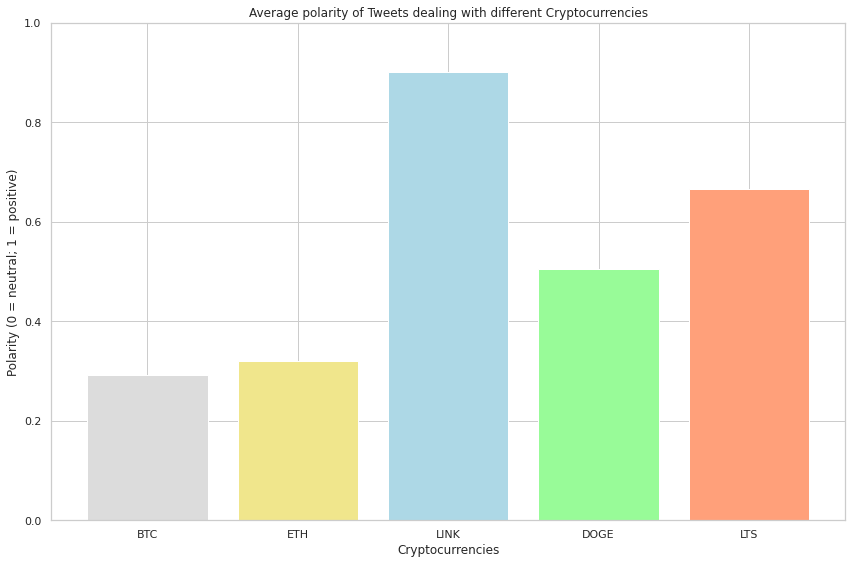

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# to have a nicer background on the plot
sns.set(style = "whitegrid")

# first we create a figure and the axes
fig, ax = plt.subplots(figsize = (12,8))

# filling the figure and axes
ax.bar(grouped_df["Cryptocurrency"][0], grouped_df["Sentiment"][0], color = "gainsboro", label = "BTC")
ax.bar(grouped_df["Cryptocurrency"][1], grouped_df["Sentiment"][1], color = "khaki", label = "ETH")
ax.bar(grouped_df["Cryptocurrency"][2], grouped_df["Sentiment"][2], color = "lightblue", label = "LINK")
ax.bar(grouped_df["Cryptocurrency"][3], grouped_df["Sentiment"][3], color = "palegreen", label = "DOGE")
ax.bar(grouped_df["Cryptocurrency"][4], grouped_df["Sentiment"][4], color = "lightsalmon", label = "LTC")

# setting the limit of the y-axis, so that we can also have the '1' tick label, otherwise we would have only until '0.8'
ax.set_ylim([0, 1])

# setting labels for x and y axes
ax.set_ylabel("Polarity (0 = neutral; 1 = positive)")
ax.set_xlabel("Cryptocurrencies")

# adding the title to the plot
plt.title('Average polarity of Tweets dealing with different Cryptocurrencies')

# to have a nicer output
fig.tight_layout()

plt.show()